<h1 style="text-align:center;">Лабораторная работа № 1 </h1>
<h2 style="text-align:center;"><span>Разведочный анализ данных с помощью PySpark</span></h2>

<h4 >1. Разведочный анализ выбранного датасета с определением типов признаков в датасете </h4>

<span>  1.1. Инициализации базовой функциональности PySpark</span>

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[*]")\
    .appName('SOBD-22')\
    .getOrCreate()

<span>1.2. Чтение данных из файла формата CSV и определение типов признаков</span>

In [3]:
data = spark.read.csv(
    'WeatherEvents_Jan2016-Dec2021.csv', 
    sep=',', 
    header=True,
    inferSchema=True
    )
data.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime(UTC): timestamp (nullable = true)
 |-- EndTime(UTC): timestamp (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- TimeZone: string (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- LocationLat: double (nullable = true)
 |-- LocationLng: double (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: integer (nullable = true)



In [4]:
data.show(10)

+-------+----+--------+-------------------+-------------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId|Type|Severity|     StartTime(UTC)|       EndTime(UTC)|Precipitation(in)|   TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode|
+-------+----+--------+-------------------+-------------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|    W-1|Snow|   Light|2016-01-06 23:14:00|2016-01-07 00:34:00|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-2|Snow|   Light|2016-01-07 04:14:00|2016-01-07 04:54:00|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-3|Snow|   Light|2016-01-07 05:54:00|2016-01-07 15:34:00|             0.03|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
|    W-4|Snow|   Light|2016-

<h4 >2. Разведочный анализ выбранного датасета с определением пропущенных значений и их устранением </h4>

<span>2.1. Определение количества пропущенных значений</span>

In [5]:
from pyspark.sql.functions import col,isnan,when,count
columns = ['EventId', 'Type', 'Severity', 'Precipitation(in)', 'TimeZone', 'AirportCode', 'LocationLat', 'LocationLng', 'City', 'County', 'State', 'ZipCode']
data_null = data.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in columns])
data_null.show()

+-------+----+--------+-----------------+--------+-----------+-----------+-----------+-----+------+-----+-------+
|EventId|Type|Severity|Precipitation(in)|TimeZone|AirportCode|LocationLat|LocationLng| City|County|State|ZipCode|
+-------+----+--------+-----------------+--------+-----------+-----------+-----------+-----+------+-----+-------+
|      0|   0|       0|                0|       0|          0|          0|          0|14563|     0|    0|  59234|
+-------+----+--------+-----------------+--------+-----------+-----------+-----------+-----+------+-----+-------+



<span>2.2. Удаление строк с пропущенными значениями</span>

In [6]:
print('До удаления: \t', data.count(), 'строк')
data2 = data.na.drop()
print('После удаления: \t', data2.count(), 'строк')

До удаления: 	 7479165 строк
После удаления: 	 7419931 строк


<h4 >3. Разведочный анализ выбранного датасета с определением выбросов и их устранением </h4>

<span>3.1. Нахождение 25%, 50% и 75% квартилей, межквартильного диапазона</span>

In [7]:
Quantile = data.approxQuantile('Precipitation(in)', [0.25, 0.5, 0.75], 0.01)
Q1 = Quantile[0]
Q2 = Quantile[1]
Q3 = Quantile[2]
IQR = Q3 - Q1

<span>3.2. Удаление строк с выбросами</span>

In [8]:
print('До удаления: \t', data.count(), 'строк')
#, 'LocationLat', 'LocationLng', 'ZipCode'
columns = ['Precipitation(in)']

data3 = data.filter((data['Precipitation(in)'] <= (Q3+1.5*IQR)) & (data['Precipitation(in)'] >= (Q1-1.5*IQR)))
 
print('После удаления: \t', data3.count(), 'строк')

До удаления: 	 7479165 строк
После удаления: 	 6341972 строк


<h4 >4. Разведочный анализ выбранного датасета с расчетом статистических показателей признаков (средних, квартилей и т.д.) </h4>

In [9]:
data.select('Precipitation(in)', 'LocationLat', 'LocationLng', 'ZipCode').summary().show()

+-------+-------------------+------------------+------------------+------------------+
|summary|  Precipitation(in)|       LocationLat|       LocationLng|           ZipCode|
+-------+-------------------+------------------+------------------+------------------+
|  count|            7479165|           7479165|           7479165|           7419931|
|   mean|0.09518491703279378|38.733361884722655|-91.92212567345294|  52478.0940247288|
| stddev| 0.9185906487600151| 5.464814681895543|13.479160326439033|25714.897114212625|
|    min|                0.0|           24.5571|          -124.555|              1022|
|    25%|                0.0|           34.4978|          -97.8283|             31314|
|    50%|                0.0|            39.275|          -89.8222|             54017|
|    75%|               0.05|            42.955|          -81.9565|             73521|
|    max|            1104.13|           48.9402|          -67.7928|             99362|
+-------+-------------------+--------------

<h4 >5. Разведочный анализ выбранного датасета с визуализацией распределения наиболее важных признаков </h4>

<span>5.1. Создание укороченного датасета, для построения графиков распределения признаков</span>

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

truncated_df = data.where((data['Precipitation(in)'] > 0.5) &  (data['Precipitation(in)'] < 10))
print('Количество строк: \t', truncated_df.count(), 'строк')

pandas_df = truncated_df.toPandas()

Количество строк: 	 259203 строк


c:\Users\criva\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
c:\Users\criva\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<span>5.2. Визуализация распределения количества осадков</span>

Text(0, 0.5, 'Количество')

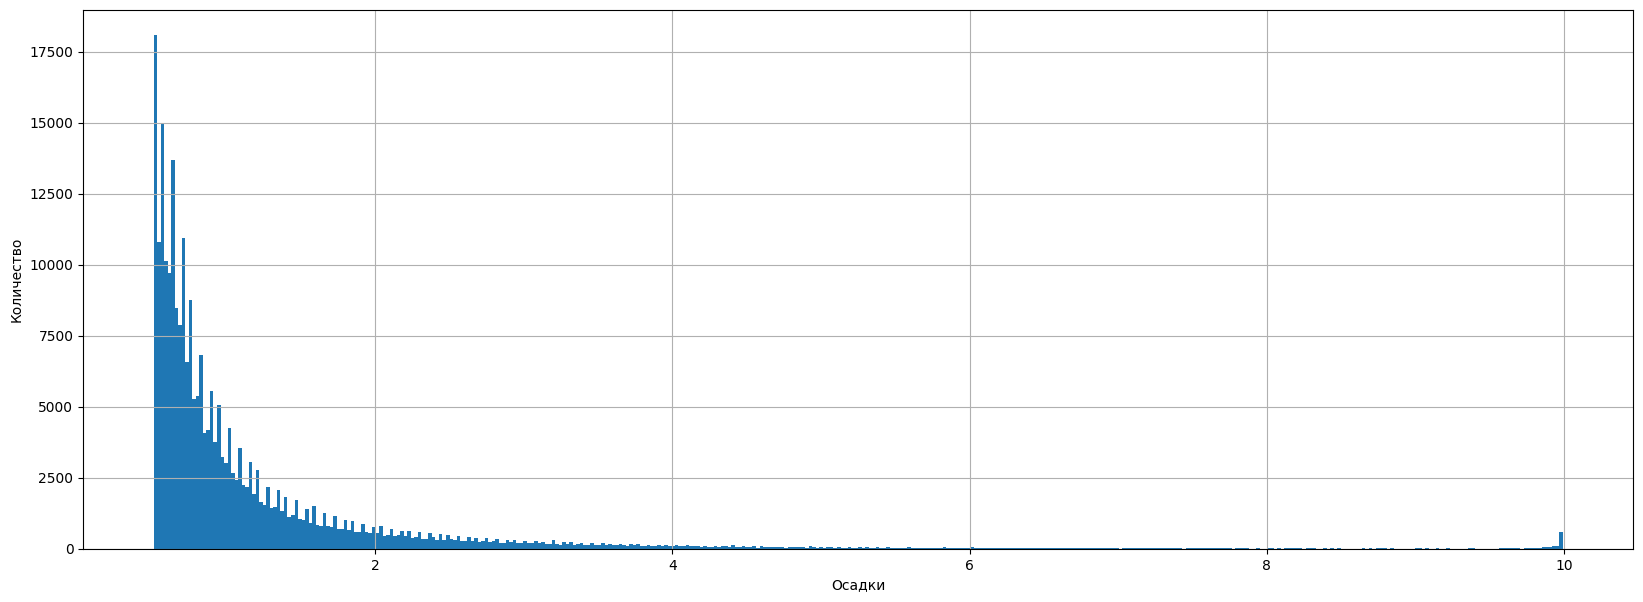

In [11]:
plt.subplots(figsize=(20, 7))
pandas_df['Precipitation(in)'].hist(bins=400)
plt.xlabel('Осадки')
plt.ylabel('Количество')

<span>5.3. Визуализация распределения номеров почтового индекса</span>

Text(0, 0.5, 'Количество')

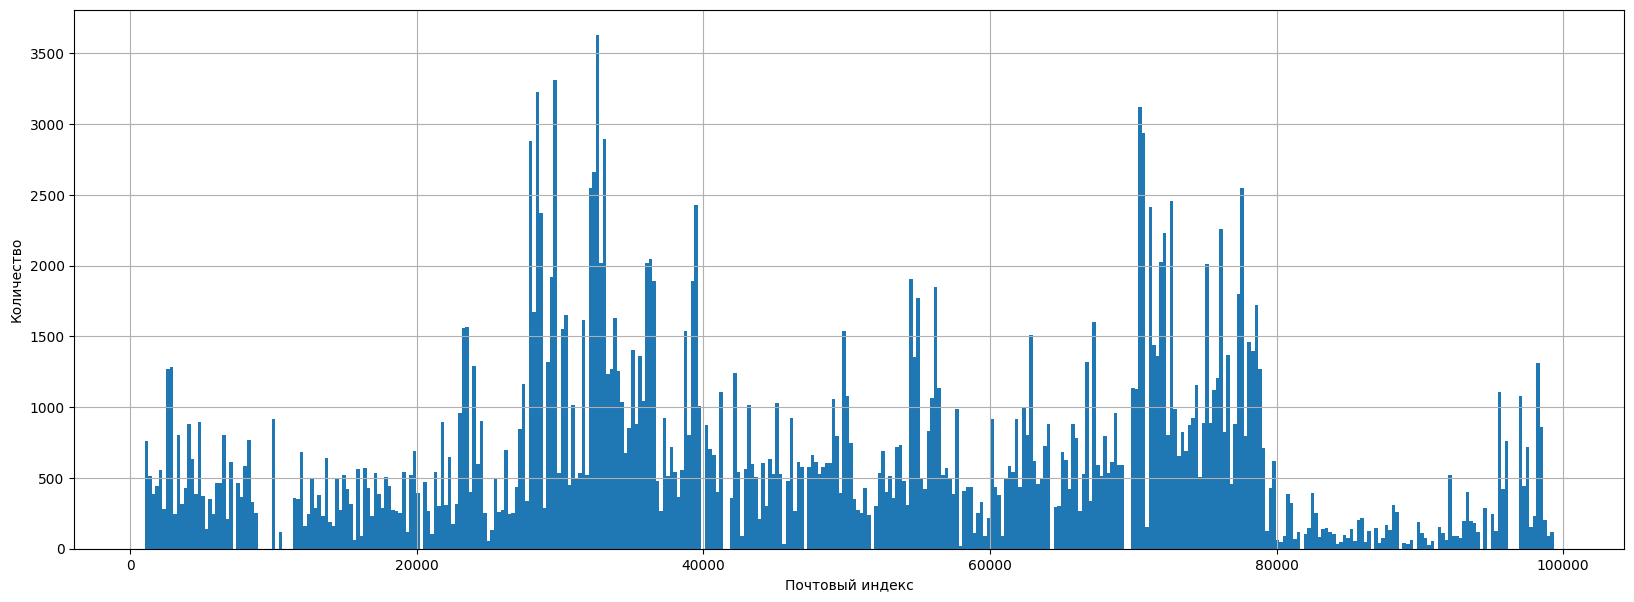

In [12]:
plt.subplots(figsize=(20, 7))
pandas_df['ZipCode'].hist(bins=400)
plt.xlabel('Почтовый индекс')
plt.ylabel('Количество')

<h4 >6. Разведочный анализ выбранного датасета с определением корреляций между признаками </h4>

<span>6.1. Построим диаграмму рассеяния для определения корреляции между признаками Широты и Долготы</span>

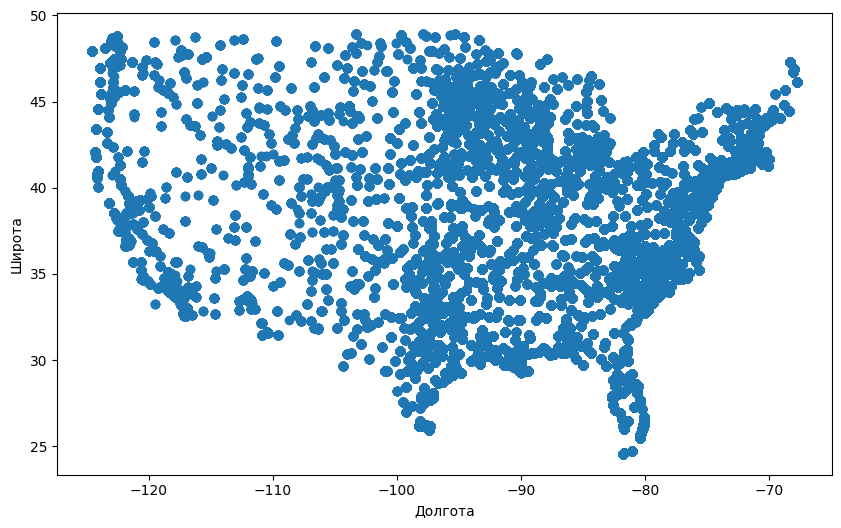

In [14]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(pandas_df['LocationLng'], pandas_df['LocationLat'])

ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.show()


<span>6.2. Построим диаграмму рассеяния для определения корреляции между признаками Широты и количества выпадавшего снега</span>

c:\Users\criva\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
c:\Users\criva\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


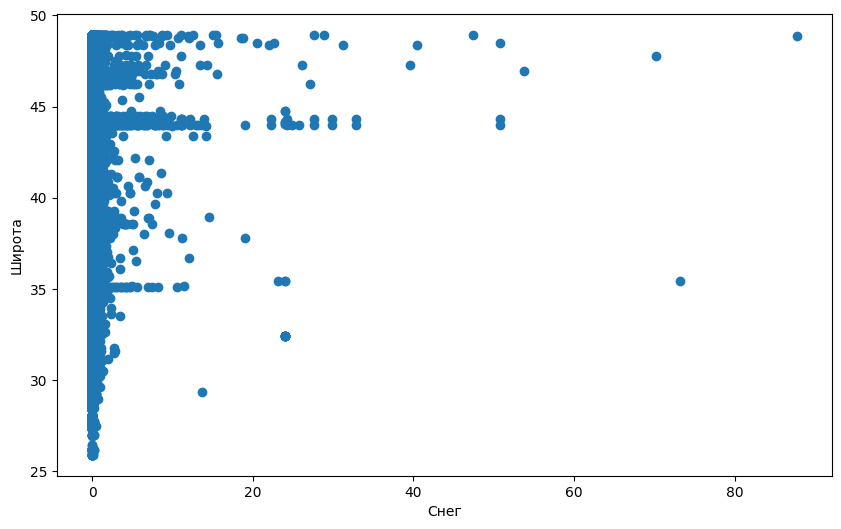

In [33]:
truncated_df2 = data.where(data['Type'] == 'Snow')
pandas_df2 = truncated_df2.toPandas()
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(pandas_df2['Precipitation(in)'], pandas_df2['LocationLat'])

ax.set_xlabel('Снег')
ax.set_ylabel('Широта')
plt.show()